In [1]:
import os, sys, time
import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torchvision.models as models

from blazeface import BlazeFace

from read_video_1 import VideoReader
from face_extract_1 import FaceExtractor

from torchvision.transforms import Normalize

from concurrent.futures import ThreadPoolExecutor

In [2]:
TRAIN_SAMPLE_FOLDER = 'dfdc_train_part_0'

In [3]:
train_dir = TRAIN_SAMPLE_FOLDER
train_videos = sorted([x for x in os.listdir(train_dir) if x[-4:] == ".mp4"])
len(train_videos)

1334

In [4]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 1.3.1
CUDA version: None
cuDNN version: None


In [5]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cpu')

In [6]:
sys.path.insert(0, "BlazeFace-PyTorch")

In [7]:
facedet = BlazeFace().to(gpu)
facedet.load_weights("BlazeFace-PyTorch/blazeface.pth")
facedet.load_anchors("BlazeFace-PyTorch/anchors.npy")
_ = facedet.train(False)

In [8]:
frames_per_video = 17

video_reader = VideoReader()
video_read_fn = lambda x: video_reader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [10]:
#input_size = 224

In [11]:
#facedet.input_size = input_size
#facedet.input_size

In [9]:
def plot_detections(img, detections, with_keypoints=True):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.grid(False)
    ax.imshow(img)
    
    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    print("Found %d faces" % detections.shape[0])
        
    for i in range(detections.shape[0]):
        ymin = detections[i, 0] * img.shape[0]
        xmin = detections[i, 1] * img.shape[1]
        ymax = detections[i, 2] * img.shape[0]
        xmax = detections[i, 3] * img.shape[1]

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor="r", facecolor="none", 
                                 alpha=detections[i, 16])
        
        ax.add_patch(rect)

        if with_keypoints:
            for k in range(6):
                kp_x = detections[i, 4 + k*2    ] * img.shape[1]
                kp_y = detections[i, 4 + k*2 + 1] * img.shape[0]
                circle = patches.Circle((kp_x, kp_y), radius=0.5, linewidth=1, 
                                        edgecolor="lightskyblue", facecolor="none", 
                                        alpha=detections[i, 16])
                ax.add_patch(circle)
        
    plt.show()

In [10]:
def read_frame(video_path):
    capture = cv2.VideoCapture(video_path)
    ret, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (128, 128))
    capture.release()
    return frame

In [11]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)

In [12]:
def isotropically_resize_image(img, size, resample=cv2.INTER_AREA):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h), interpolation=resample)
    return resized


def make_square_image(img):
    h, w = img.shape[:2]
    size = max(h, w)
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

In [13]:
class MyResNeXt(models.resnet.ResNet):
    def __init__(self, training=True):
        super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
                                        layers=[3, 4, 6, 3], 
                                        groups=32, 
                                        width_per_group=4)
        self.fc = nn.Linear(2048, 1)

In [14]:
checkpoint = torch.load("resnext.pth", map_location=gpu)

model = MyResNeXt().to(gpu)
model.load_state_dict(checkpoint)
_ = model.eval()

del checkpoint

In [15]:
input_size = 224

In [16]:
def predict_on_video(video_path, batch_size):
    try:
        # Find the faces for N frames in the video.
        faces = face_extractor.process_video(video_path)

        # Only look at one face per frame.
        face_extractor.keep_only_best_face(faces)
        
        if len(faces) > 0:
            # NOTE: When running on the CPU, the batch size must be fixed
            # or else memory usage will blow up. (Bug in PyTorch?)
            x = np.zeros((batch_size, input_size, input_size, 3), dtype=np.uint8)

            # If we found any faces, prepare them for the model.
            n = 0
            for frame_data in faces:
                for face in frame_data["faces"]:
                    # Resize to the model's required input size.
                    # We keep the aspect ratio intact and add zero
                    # padding if necessary.                    
                    resized_face = isotropically_resize_image(face, input_size)
                    resized_face = make_square_image(resized_face)

                    if n < batch_size:
                        x[n] = resized_face
                        n += 1
                    else:
                        print("WARNING: have %d faces but batch size is %d" % (n, batch_size))
                    
                    # Test time augmentation: horizontal flips.
                    # TODO: not sure yet if this helps or not
                    #x[n] = cv2.flip(resized_face, 1)
                    #n += 1

            if n > 0:
                x = torch.tensor(x, device=gpu).float()

                # Preprocess the images.
                x = x.permute((0, 3, 1, 2))

                for i in range(len(x)):
                    x[i] = normalize_transform(x[i] / 255.)

                # Make a prediction, then take the average.
                with torch.no_grad():
                    y_pred = model(x)
                    y_pred = torch.sigmoid(y_pred.squeeze())
                    return y_pred[:n].mean().item()

    except Exception as e:
        print("Prediction error on video %s: %s" % (video_path, str(e)))

    return 0.5

In [17]:
#video_path = TRAIN_SAMPLE_FOLDER
#filenames = list(os.listdir(os.path.join(TRAIN_SAMPLE_FOLDER)))
#filenames
input_dir = train_dir
video_path = os.path.join(input_dir, np.random.choice(os.listdir(input_dir)))
video_path

'dfdc_train_part_0/zfkgevlnur.mp4'

In [18]:
frame = read_frame(video_path)

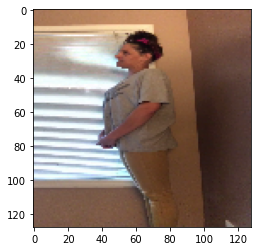

In [19]:
plt.imshow(frame)

In [20]:
detections = facedet.predict_on_image(frame)
detections.shape

torch.Size([1, 17])

In [21]:
detections

tensor([[0.1440, 0.3907, 0.2842, 0.5309, 0.4153, 0.1710, 0.4605, 0.1846, 0.4014,
         0.1965, 0.4022, 0.2314, 0.4282, 0.1950, 0.5325, 0.2308, 0.9941]])

Found 1 faces


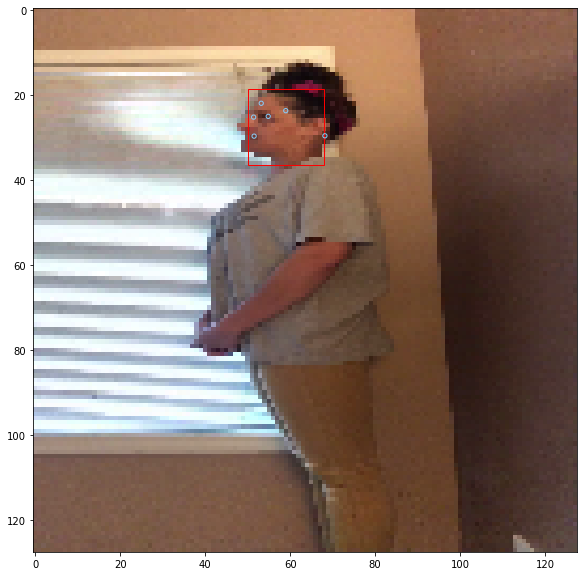

In [22]:
plot_detections(frame, detections)

In [23]:
frame1 = read_frame("dfdc_train_part_0/hhyxweyjlt.mp4")
frame2 = read_frame("dfdc_train_part_0/shnsajrsow.mp4")

batch = np.stack([frame1, frame2])
batch.shape

(2, 128, 128, 3)

In [24]:
%time detections = facedet.predict_on_batch(batch)

CPU times: user 36.7 ms, sys: 9.39 ms, total: 46 ms
Wall time: 44.2 ms


Found 1 faces


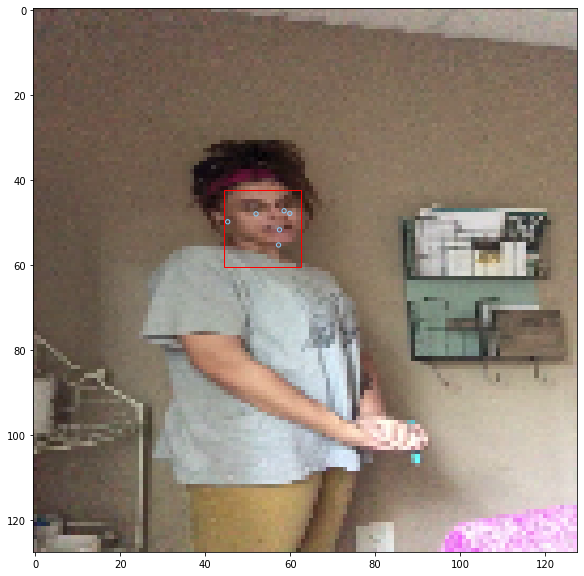

In [25]:
plot_detections(frame1, detections[0])

Found 1 faces


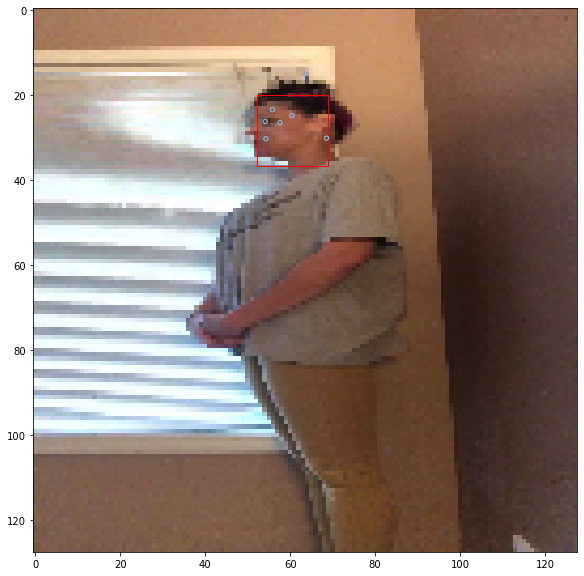

In [26]:
plot_detections(frame2, detections[1])

In [27]:
def predict_on_video_set(videos, num_workers):
    def process_file(i):
        filename = videos[i]
        y_pred = predict_on_video(os.path.join(train_dir, filename), batch_size=frames_per_video)
        return y_pred

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        predictions = ex.map(process_file, range(len(videos)))

    return list(predictions)

In [28]:
speed_test = True  # you have to enable this manually

In [43]:
if speed_test:
    start_time = time.time()
    speedtest_videos = train_videos[:5]
    predictions = predict_on_video_set(speedtest_videos, num_workers=4)
    elapsed = time.time() - start_time
    print("Elapsed %f sec. Average per video: %f sec." % (elapsed, elapsed / len(speedtest_videos)))

Elapsed 13.002382 sec. Average per video: 2.600476 sec.


In [45]:
predictions = predict_on_video_set(train_videos, num_workers=4)

In [46]:
predictions

[0.9588339328765869,
 0.25685396790504456,
 0.8434793949127197,
 0.6351836323738098,
 0.735997200012207,
 0.49018174409866333,
 0.49164581298828125,
 0.9296267032623291,
 0.9227939248085022,
 0.8990268707275391,
 0.4635474979877472,
 0.9196307063102722,
 0.9512794613838196,
 0.4645029306411743,
 0.9750513434410095,
 0.8403045535087585,
 0.780538022518158,
 0.8153762221336365,
 0.6565102934837341,
 0.5475478768348694,
 0.9636801481246948,
 0.6700523495674133,
 0.521748423576355,
 0.4500449001789093,
 0.17733104526996613,
 0.4873693585395813,
 0.2282855361700058,
 0.9335745573043823,
 0.9627174139022827,
 0.7008760571479797,
 0.6658194661140442,
 0.9888696074485779,
 0.42235302925109863,
 0.5709847807884216,
 0.9154482483863831,
 0.6905459761619568,
 0.4535309970378876,
 0.9563425779342651,
 0.9617422819137573,
 0.5395252108573914,
 0.7846068739891052,
 0.5453954339027405,
 0.9793335199356079,
 0.8054198026657104,
 0.8722274303436279,
 0.4726569354534149,
 0.9773426055908203,
 0.57417064